In [1]:
import pandas as pd
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df_formatted=pd.DataFrame(columns=["benchmark","prior","algorithm","fidelity","seed","score"])
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [2]:
df_dict={"all":{"all":df}}
df_dict={"all":{"RS+HB+PB":df.loc[(df["algorithm"]=="random_search")|(df["algorithm"]=="hyperband")|(df["algorithm"]=="priorband")]}}
df_dict={"good+bad":{"all":df.loc[(df["prior"]=="good")|(df["prior"]=="bad")]}}
df_dict["good+bad"]["RS+HB+PB"]=df.loc[((df["prior"]=="good")|(df["prior"]=="bad"))&((df["algorithm"]=="random_search")|(df["algorithm"]=="hyperband")|(df["algorithm"]=="priorband"))]
for priortype in df["prior"].unique():
    df_dict[priortype]={}
    df_dict[priortype]["all"]=df.loc[df["prior"]==priortype]
    df_dict[priortype]["RS+HB+PB"]=df.loc[(df["prior"]==priortype)&((df["algorithm"]=="random_search")|(df["algorithm"]=="hyperband")|(df["algorithm"]=="priorband"))]
print(df_dict["good+bad"].keys())

dict_keys(['all', 'RS+HB+PB'])


In [3]:
def autorank_formatter(df:pd.DataFrame,system_id:str,metric:str,used_fidelity_min=None, used_fidelity_max:float=None,):
    if not used_fidelity_max:
        used_fidelity_max=max(df["used_fidelity"])
    if not used_fidelity_min:
        used_fidelity_min=min(df["used_fidelity"])
    df_collector=[]
    for algo in df[system_id].unique():
        algo_df=pd.DataFrame(df.loc[(df[system_id]==algo)&(df["used_fidelity"]<=used_fidelity_max)&(df["used_fidelity"]>=used_fidelity_min)][metric])
        algo_df=algo_df.rename(columns={metric:algo})
        df_collector.append(algo_df[algo].to_list())
    df_collector=list(zip(*df_collector))
    return pd.DataFrame(df_collector,columns=df[system_id].unique())

system_id="algorithm"
df_dict_autorank={}
for priortype in ["good+bad","good","bad"]:
    df_dict_autorank[priortype]=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value")

In [4]:
from autorank import autorank, create_report, plot_stats
from matplotlib import pyplot as plt

# PriorBand Analysis with Autorank for all cost/time/fidelities combined/ignored
for priortype in df_dict_autorank.keys():
    print(f"Random Search vs. HyperBand vs. PriorBand on Prior: {priortype} \n")
    result=autorank(df_dict_autorank[priortype],
            alpha=0.05,
            verbose=False)
#     create_report(result)
#     plot_stats(result)
    plt.show()

Random Search vs. HyperBand vs. PriorBand on Prior: good+bad 



c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Random Search vs. HyperBand vs. PriorBand on Prior: good 



c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Random Search vs. HyperBand vs. PriorBand on Prior: bad 



c:\Users\Amega\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [29]:
import numpy as np
system_id="algorithm"
steps=18
min_f=1
max_f=25.2
quantiles=True
df_dict_autorank_fidelities={}
for priortype in ["good+bad","good","bad"]:
    df_dict_autorank_fidelities[priortype]={}
    if quantiles:
        linspace=np.quantile(df_dict[priortype]["RS+HB+PB"].loc[(df_dict[priortype]["RS+HB+PB"]["used_fidelity"]>=min_f)&(df_dict[priortype]["RS+HB+PB"]["used_fidelity"]<=max_f)]["used_fidelity"],np.linspace(0,1,num=steps,endpoint=True))
        for n,f in enumerate(linspace[:-1]):
            df_at_fidelity=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value",f,linspace[n+1]) 
            passed=True
            for system in df_at_fidelity.columns:
                if len(df_at_fidelity[system])<5:
                    passed=False
            if passed:
                df_dict_autorank_fidelities[priortype][linspace[n+1]]=df_at_fidelity
    else:
        for f in np.linspace(max(min_f,min(df_dict[priortype]["RS+HB+PB"]["used_fidelity"])),min(max_f,max(df_dict[priortype]["RS+HB+PB"]["used_fidelity"])),num=50,endpoint=True):
            print(f"{priortype}, {round(f,4)}           ",end="\r",flush=True)
            df_dict_autorank_fidelities[priortype][f]=autorank_formatter(df_dict[priortype]["RS+HB+PB"],"algorithm","value",used_fidelity_max=f)

In [30]:

scores={}
for priortype in df_dict_autorank_fidelities.keys():
    fidelities_steps=list(df_dict_autorank_fidelities[priortype].keys())
    scores[priortype]={}
    for system in df_dict_autorank[priortype].keys():
        scores[priortype][system]=[]
    for f in fidelities_steps:
        result_frame=autorank(df_dict_autorank_fidelities[priortype][f],
                alpha=0.5,
                verbose=False)[0]
        for system in result_frame.index:
            scores[priortype][system].append(result_frame.loc[system,"meanrank"])
print(scores)

{'good+bad': {'random_search': [1.9333333333333333, 1.8666666666666667, 1.8883333333333334, 1.7626923076923078, 1.745897435897436, 1.79125, 1.70875, 1.9805714285714286, 1.874375, 1.7707692307692309, 1.8331428571428572, 1.852121212121212, 1.8762962962962964, 1.8793548387096775, 1.9303030303030304, 1.9806060606060607], 'hyperband': [1.9866666666666666, 1.9666666666666666, 1.9375, 2.068846153846154, 1.9905128205128204, 1.97875, 1.9329166666666666, 1.8371428571428572, 1.93375, 2.0702564102564103, 1.744, 1.8957575757575758, 1.8955555555555557, 1.8361290322580646, 1.9515151515151514, 1.896969696969697], 'priorband': [2.08, 2.1666666666666665, 2.174166666666667, 2.1684615384615387, 2.2635897435897436, 2.23, 2.3583333333333334, 2.1822857142857144, 2.191875, 2.158974358974359, 2.422857142857143, 2.252121212121212, 2.228148148148148, 2.284516129032258, 2.118181818181818, 2.1224242424242425]}, 'good': {'random_search': [1.7975, 1.755, 1.6525, 1.596, 1.59625, 1.615, 1.56, 1.5491666666666666, 1.595

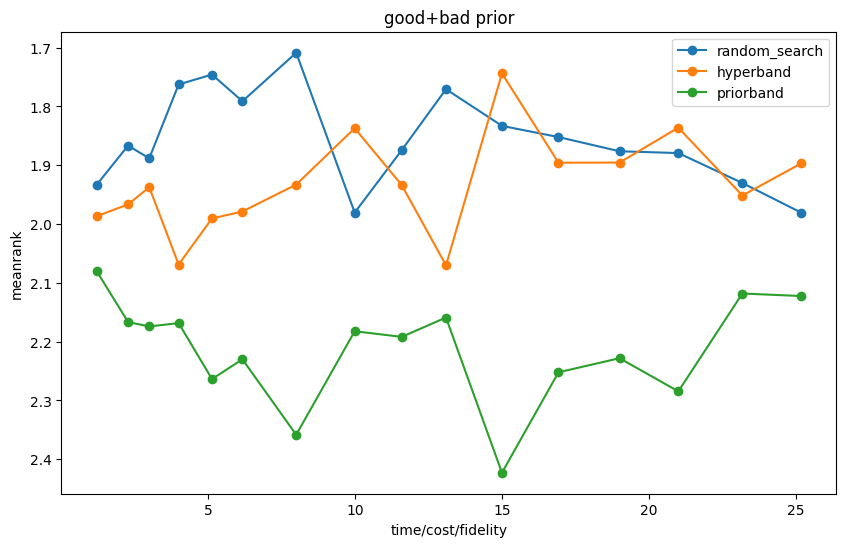

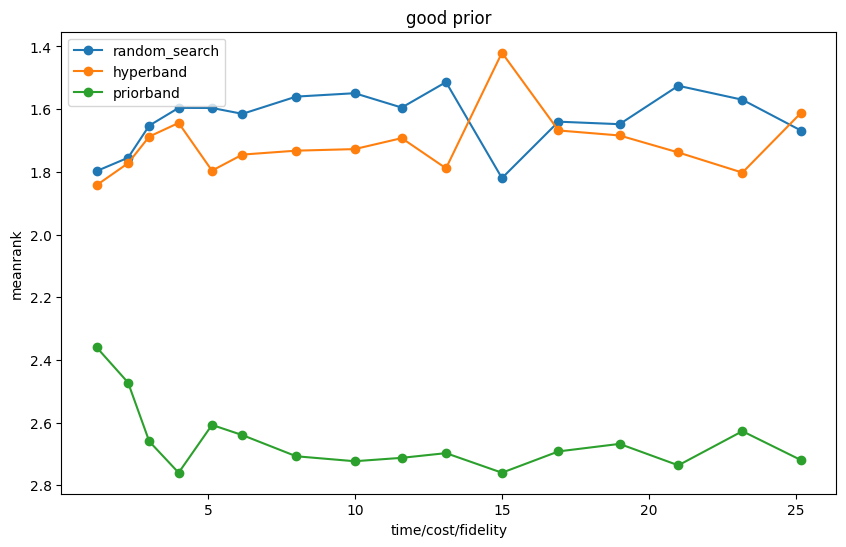

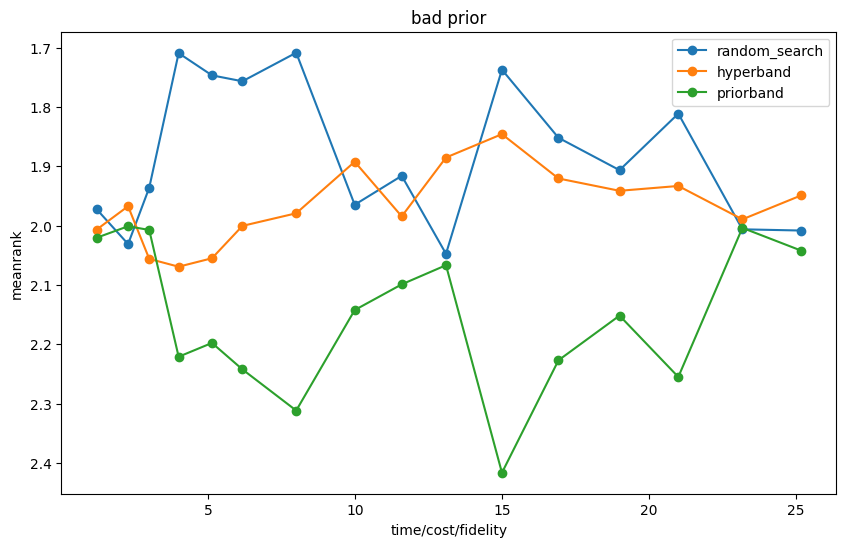

In [31]:
for priortype in scores.keys():
    _, axis = plt.subplots(figsize=(10, 6))
    for system_id in scores[priortype]:
        axis.errorbar(
            fidelities_steps,
            scores[priortype][system_id],
            fmt="o-",
            capsize=3,
            label=system_id,
        )
    axis.set_xlabel("time/cost/fidelity")
    axis.set_ylabel("meanrank")
    axis.set_title(f"{priortype} prior")
    axis.invert_yaxis()
    axis.legend()
plt.show()

In [ ]:
fidelities_steps=list(df_dict_autorank_fidelities["good"].keys())
scores={}
for priortype in df_dict_autorank_fidelities.keys():
    scores[priortype]={}
    for system in df_dict_autorank[priortype].keys():
        scores[priortype][system]=[]
    for f in fidelities_steps:
        result_frame=autorank(df_dict_autorank_fidelities[priortype][f],
                alpha=0.5,
                verbose=False)[0]
        for system in result_frame.index:
            scores[priortype][system].append(result_frame.loc[system,"meanrank"])
print(scores)

KeyError: 1.45